In [1]:
from optionCombo import optionModel,preInit

C:\Users\5565\AppData\Local\Programs\Python\Python310\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


# Collect Deribit option data

In [2]:
import requests
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from datetime import datetime
import random
import time
from tqdm.notebook import tqdm
#most of the code comes from this repo https://github.com/schepal/deribit_data_collector/blob/master/deribit_data.py

def request_get(url):
    while True:
        try:
            page = requests.get(url)
            return page.json()['result']
        except:time.sleep(random.randint(1,5))
        
def get_options_list():
    data = {'currency': currency, 'kind': 'option'}
    r = requests.get(url + 'get_instruments', data)
    df = pd.DataFrame(r.json()['result'])
    cols = ['expiration_timestamp', 'option_type', 'instrument_name', 'strike']
    return df[cols]
def get_option_urls():
    url_storage = []
    options_list = get_options_list()
    request_url = url + 'get_order_book?instrument_name='
    for option in range(len(options_list)):
        data = request_url + options_list.instrument_name.values[option]
        url_storage.append(data)
    return url_storage
def collect_clean_data():

    raw_data = []
    pool = ThreadPoolExecutor(max_workers=10)
    print("Collecting data...")
    urls = get_option_urls()
    for asset in tqdm(pool.map(request_get,urls ),total=len(urls)):
        raw_data.append(asset)
    data = pd.DataFrame(raw_data)

    option_data = data
    option_data['infos'] = option_data['instrument_name'].apply(lambda x: x.split('-'))
    option_data['expiration'] = option_data['infos'].apply(
        lambda x: pd.to_datetime(x[1]))  # pd.to_datetime(option_data['expiration'])#
    option_data['is_call'] = option_data['infos'].apply(lambda x: x[-1])
    option_data['K'] = option_data['infos'].apply(lambda x: x[-2])
    option_data['ticker'] = option_data['infos'].apply(lambda x: x[0])
    option_data['askIv'] = option_data['ask_iv'] / 100  # option_data['askIV']#
    option_data['bidIv'] = option_data['bid_iv'] / 100  # option_data['bidIV']#
    option_data[['K', 'bidIV', 'askIV']] = option_data[['K', 'bidIv', 'askIv']].astype('float')

    option_data['expiry'] = option_data['expiration'].apply(lambda x: (pd.to_datetime(x) - datetime.now()) / (pd.to_timedelta('365d')))

    option_data = option_data[['is_call','K','askIV','bidIV','expiry','expiration']]
    expirList = option_data.sort_values(by=['expiration'])['expiration'].unique()


    return option_data,expirList

In [3]:
global currency
global url
currency = 'BTC'
url = 'https://www.deribit.com/api/v2/public/'
option_data,expirList = collect_clean_data()

  0%|          | 0/728 [00:00<?, ?it/s]

In [4]:
expirList

array(['2023-06-18T00:00:00.000000000', '2023-06-19T00:00:00.000000000',
       '2023-06-20T00:00:00.000000000', '2023-06-23T00:00:00.000000000',
       '2023-06-30T00:00:00.000000000', '2023-07-07T00:00:00.000000000',
       '2023-07-28T00:00:00.000000000', '2023-08-25T00:00:00.000000000',
       '2023-09-29T00:00:00.000000000', '2023-12-29T00:00:00.000000000',
       '2024-03-29T00:00:00.000000000'], dtype='datetime64[ns]')

In [12]:
# choose a expiry date, doesn't support mutiple expiry dates at the moment
expirDate = '2023-07-28T00:00:00.000000000'

In [13]:
# this is what the option Dataframe should look like 
option_data

,is_call,K,askIV,bidIV,expiry,expiration
0,C,22000.0,4.2244,0.0000,-0.001454,2023-06-18
1,P,22000.0,4.5721,0.0000,-0.001454,2023-06-18
2,C,22500.0,0.0000,0.0000,-0.001454,2023-06-18
3,P,22500.0,4.0928,0.0000,-0.001454,2023-06-18
4,C,23000.0,4.6315,0.0000,-0.001454,2023-06-18
...,...,...,...,...,...,...
723,P,90000.0,0.0000,0.0000,0.779368,2024-03-29
724,C,100000.0,0.7096,0.6882,0.779368,2024-03-29
725,P,100000.0,0.0000,0.0000,0.779368,2024-03-29
726,C,120000.0,0.7614,0.7140,0.779368,2024-03-29


# Collect price data, this is used for determine asset price range

In [14]:
import ccxt
def fetchprice(symbol,exchange = 'binance'):
    res = {}
    exchange = getattr(ccxt, exchange)()


    while True:
        try:
            data = exchange.fetch_ohlcv(symbol, '15m', None, 1000)
            header = ["Timestamp", "open", "high", "low", "close", "volume"]
            df = pd.DataFrame(data, columns=header)
            df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
            break
        except Exception as e:
            print(e)
            time.sleep(1)
    for i in range(20):
        while True:
            try:
                since = df.Timestamp.values[0] - 1000*15*60*1000
                data = exchange.fetch_ohlcv(symbol, '15m', since, 1000)
                header = ["Timestamp", "open", "high", "low", "close", "volume"]
                df1 = pd.DataFrame(data, columns=header)
                df1 = df1[["Timestamp", "open", "high", "low", "close", "volume"]]
                df = pd.concat([df1,df]).reset_index(drop=True)
                break
            except Exception as e:
                print(e)
                time.sleep(1)
    df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'] / 1000, unit="s")
    df["open"] = pd.to_numeric(df["open"])
    df["high"] = pd.to_numeric(df["high"])
    df["low"] = pd.to_numeric(df["low"])
    df["close"] = pd.to_numeric(df["close"])
    df["volume"] = pd.to_numeric(df["volume"])
    return df

In [15]:
pricedata = fetchprice('BTCUSDT')

In [16]:
# this is what the price Dataframe should look like 
pricedata

,Timestamp,open,high,low,close,volume
0,2022-11-11 11:00:00,17334.41,17426.66,17298.51,17401.57,2893.07144
1,2022-11-11 11:15:00,17401.57,17418.38,17354.43,17376.83,2914.43503
2,2022-11-11 11:30:00,17377.63,17467.60,17323.15,17346.18,2876.26657
3,2022-11-11 11:45:00,17346.18,17368.21,17294.01,17350.70,2341.06681
4,2022-11-11 12:00:00,17349.45,17386.38,17301.28,17305.99,2264.38572
...,...,...,...,...,...,...
20995,2023-06-18 03:45:00,26544.57,26548.46,26538.17,26548.45,62.31245
20996,2023-06-18 04:00:00,26548.46,26559.63,26521.89,26524.17,172.66986
20997,2023-06-18 04:15:00,26524.16,26534.45,26521.89,26524.81,132.76456
20998,2023-06-18 04:30:00,26524.81,26539.03,26524.81,26535.77,57.99641


In [17]:
# this part of the code is for pre-compute

preOption,joined1,price = preInit.Prep( expirDate, optionDf = option_data, priceDf = pricedata, interval=3, strikePriceRange=0.3)

C:\Users\5565\AppData\Local\Programs\Python\Python310\lib\site-packages\optionCombo\preInit.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_data['per_ivs'] = option_data['bidIV'].apply(lambda x: list(np.linspace(1 * lowerIV, 1 * upperIV, 89)), 0)


In [18]:
# this part of the code is for loop through all the possible option combination of 4 call options, 1 stands for call option
# -1 stands for put options, possible input for "optionstypes" should be a two dimension list, eg. [[1,1,1],[-1,-1,1,1]]
# maxquantity is the input for maxmium possible quantity for a single option trade amount 

model = optionModel.option_model(price, joined1,preOption,optionstypes = [[1,1,1,1],[1,1],[-1,-1,1,1]], maxquantity=3)  # Init

df = model.options_model_finder()                                                                           # start looping

C:\Users\5565\AppData\Local\Programs\Python\Python310\lib\site-packages\optionCombo\optionModel.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(optionstypes)
100%|████████████████████████████████████████████████████████████████████████████| 60053/60053 [15:06<00:00, 66.24it/s]


In [19]:
# output contains all the possible combinations given the parameters, you can filter out the result as you want
df

,para,stra,loss,probal,RR,wv,wp,bv,bp,delta_starting,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium
0,"[26535.77, [0.10813552311938737, 0.10813552311...",C_25000_1__C_26000_1__C_27000_1__C_28000_1,1.000000,0.662921,11.476399,0.85,18900.608771,0.85,45928.147417,2.139860,2.872357,1.413266,46.630157,-28.594070,23.999660,6228.767713
1,"[26535.77, [0.10813552311938737, 0.10813552311...",C_25000_1__C_26000_1__C_28000_1__C_29000_1,1.000000,0.651685,12.486675,0.85,18900.608771,0.85,45928.147417,1.944803,2.799440,1.426976,48.886525,-29.924572,23.666485,5613.881076
2,"[26535.77, [0.10813552311938737, 0.10813552311...",C_25000_1__C_26000_1__C_29000_1__C_30000_1,1.000000,0.662921,13.182557,0.85,18900.608771,0.85,45928.147417,1.788787,2.726525,1.428211,51.717413,-31.843123,23.141519,5197.411895
3,"[26535.77, [0.10813552311938737, 0.10813552311...",C_25000_1__C_26000_1__C_27000_1__C_28000_2,1.000000,0.651685,12.486271,0.85,18900.608771,0.85,45928.147417,2.515685,3.536020,1.792609,59.465595,-36.225056,30.180895,7091.710967
4,"[26535.77, [0.10813552311938737, 0.10813552311...",C_25000_1__C_26000_1__C_28000_1__C_29000_2,1.000000,0.651685,13.903210,0.85,18900.608771,0.85,45928.147417,2.230400,3.426634,1.813042,62.884819,-38.249894,29.969766,6216.159862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60048,"[26535.77, [0.10813552311938737, 0.10813552311...",P_24000_-4__P_26000_-4__C_27000_-4__C_29000_-3,8.783426,0.235955,0.113851,0.85,45928.147417,0.85,26271.755674,0.273661,5.562042,5.179668,-169.967137,92.400585,82.262612,12929.727119
60049,"[26535.77, [0.10813552311938737, 0.10813552311...",P_24000_-4__P_26000_-4__C_28000_-4__C_30000_-3,9.842156,0.247191,0.101604,0.85,45928.147417,0.85,26271.755674,0.369709,5.447803,5.207082,-178.460091,97.610188,80.153581,11021.519470
60050,"[26535.77, [0.10813552311938737, 0.10813552311...",P_25000_-4__P_26000_-4__C_27000_-4__C_28000_-3,7.846244,0.213483,0.127450,0.85,45928.147417,0.85,26271.755674,0.201030,5.686750,5.321960,-167.981308,89.631696,86.437614,14638.645652
60051,"[26535.77, [0.10813552311938737, 0.10813552311...",P_25000_-4__P_26000_-4__C_28000_-4__C_29000_-3,8.773869,0.224719,0.113975,0.85,45928.147417,0.85,26271.755674,0.491662,5.589082,5.363344,-176.490913,94.878469,85.507278,12533.116082


In [21]:
temp = df.loc[  (df['probal']>0.5)&(df['mean_theta']>0)].sort_values(by=['mean_vega','probal'], ascending=[False,False])
temp

,para,stra,loss,probal,RR,wv,wp,bv,bp,delta_starting,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium
49796,"[26535.77, [0.10813552311938737, 0.10813552311...",P_23000_-3__P_26000_4__C_27000_4__C_30000_-4,1.000000,0.842697,1.367998,0.85,26271.755674,0.85,18900.608771,0.091440,0.519791,0.713373,3.332947,1.733854,24.735541,12121.607211
34494,"[26535.77, [0.10813552311938737, 0.10813552311...",P_23000_-1__P_26000_2__C_27000_3__C_30000_-3,1.000000,0.820225,1.305276,0.85,26271.755674,0.85,18900.608771,0.148773,0.379489,0.519222,2.956518,0.194823,18.890312,7513.511869
55646,"[26535.77, [0.10813552311938737, 0.10813552311...",P_23000_-4__P_25000_3__C_27000_3__C_29000_-2,1.000000,0.775281,5.635779,0.85,25043.231190,0.85,45928.147417,0.568834,0.798012,0.353966,2.138996,0.118114,13.514875,8563.088175
48576,"[26535.77, [0.10813552311938737, 0.10813552311...",P_23000_-3__P_25000_3__C_27000_1__C_29000_-1,1.000000,0.831461,2.070607,0.85,25043.231190,0.85,18900.608771,0.261613,0.159961,0.229190,1.809697,0.682727,8.816260,5195.645818
48577,"[26535.77, [0.10813552311938737, 0.10813552311...",P_23000_-3__P_25000_3__C_28000_1__C_30000_-1,1.000000,0.797753,2.367800,0.85,25043.231190,0.85,18900.608771,0.293462,0.175660,0.245259,1.643424,0.828556,9.576569,4659.634297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59540,"[26535.77, [0.10813552311938737, 0.10813552311...",P_23000_-4__P_26000_-4__C_27000_2__C_30000_-3,8.745438,0.573034,0.261481,0.85,18900.608771,0.85,29957.329126,2.565710,2.151269,2.784389,-102.509643,54.440690,41.817297,9465.184783
59656,"[26535.77, [0.10813552311938737, 0.10813552311...",P_24000_-4__P_26000_-4__C_27000_3__C_29000_-4,8.461257,0.573034,0.254858,0.85,18900.608771,0.85,29035.935763,2.799551,2.291450,2.969045,-102.977542,52.950816,46.053506,12460.354593
59660,"[26535.77, [0.10813552311938737, 0.10813552311...",P_25000_-4__P_26000_-4__C_29000_3__C_30000_-4,6.291044,0.573034,0.222002,0.85,18900.608771,0.85,29957.329126,2.847191,2.344064,3.063948,-103.057741,51.701558,46.698277,10854.765831
59657,"[26535.77, [0.10813552311938737, 0.10813552311...",P_24000_-4__P_26000_-4__C_28000_3__C_30000_-4,7.883356,0.617978,0.262454,0.85,18900.608771,0.85,29957.329126,2.776985,2.265135,2.927632,-104.736142,54.170300,42.937933,10670.530679


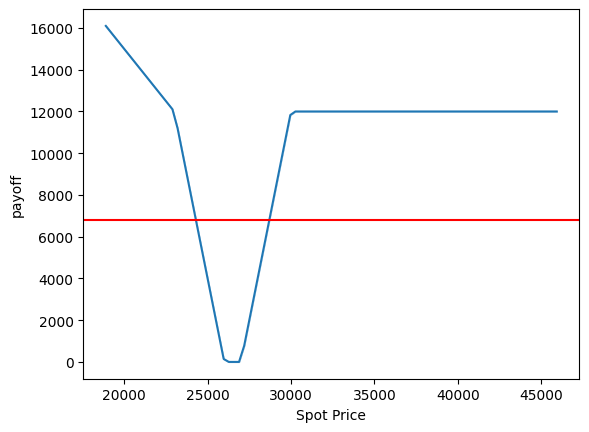

[       Price
0  343.85288,         Price
0  1147.87744,          Price
0  1217.165422,         Price
0  407.469281]
net premium 6798.735684965048
premium 12121.607211292228
Risk Reward 1.3679978124273224
probal 0.8426966292134831
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 26271.75567428225
best case, vol: 0.85 price: 18900.608770731193
min thetas -53.2763172635307
[{'type': 'P', 'strike': 23000.0, 'expiry': 0.10813552311938737, 'vol': 0.4643, 'quantity': -3, 'map': -1}, {'type': 'P', 'strike': 26000.0, 'expiry': 0.10813552311938737, 'vol': 0.41409999999999997, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10813552311938737, 'vol': 0.4025, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 30000.0, 'expiry': 0.10813552311938737, 'vol': 0.4189, 'quantity': -4, 'map': -1}]


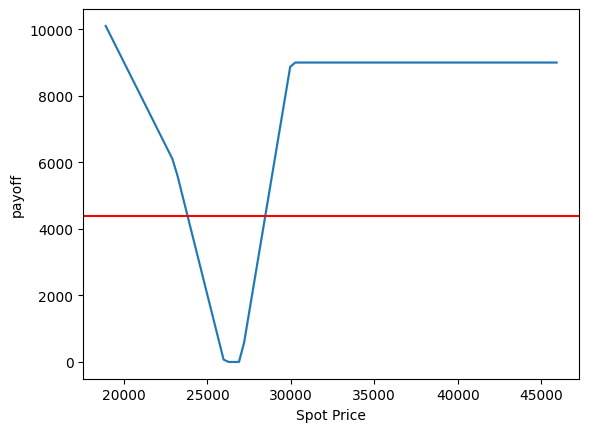

[       Price
0  343.85288,         Price
0  1147.87744,          Price
0  1217.165422,         Price
0  407.469281]
net premium 4380.990424300508
premium 7513.511868713511
Risk Reward 1.3052758055003808
probal 0.8202247191011236
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 26271.75567428225
best case, vol: 0.85 price: 18900.608770731193
min thetas -39.465171177800244
[{'type': 'P', 'strike': 23000.0, 'expiry': 0.10813552311938737, 'vol': 0.4643, 'quantity': -1, 'map': -1}, {'type': 'P', 'strike': 26000.0, 'expiry': 0.10813552311938737, 'vol': 0.41409999999999997, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10813552311938737, 'vol': 0.4025, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 30000.0, 'expiry': 0.10813552311938737, 'vol': 0.4189, 'quantity': -3, 'map': -1}]


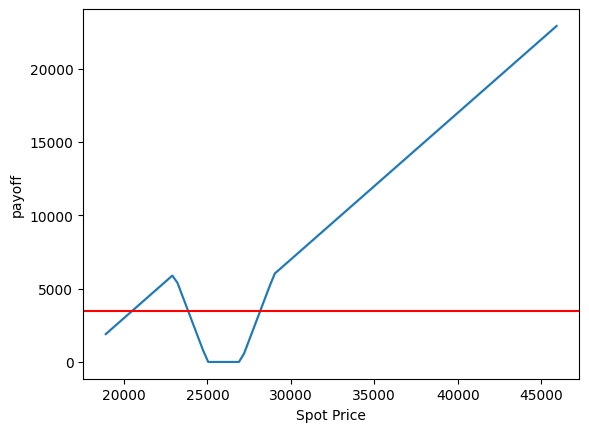

[       Price
0  343.85288,         Price
0  785.887708,          Price
0  1217.165422,         Price
0  589.258633]
net premium 3455.230604257752
premium 8563.088175467004
Risk Reward 5.635779212198328
probal 0.7752808988764045
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 25043.23119035707
best case, vol: 0.85 price: 45928.147417085056
min thetas -25.479128789176343
[{'type': 'P', 'strike': 23000.0, 'expiry': 0.10813552311938737, 'vol': 0.4643, 'quantity': -4, 'map': -1}, {'type': 'P', 'strike': 25000.0, 'expiry': 0.10813552311938737, 'vol': 0.428, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10813552311938737, 'vol': 0.4025, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 29000.0, 'expiry': 0.10813552311938737, 'vol': 0.4108, 'quantity': -2, 'map': -1}]


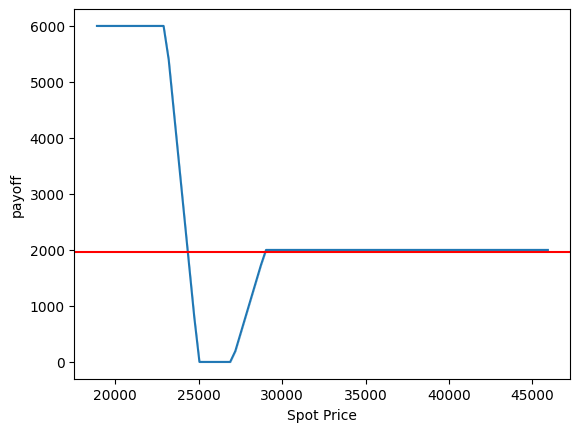

[       Price
0  343.85288,         Price
0  785.887708,          Price
0  1217.165422,         Price
0  589.258633]
net premium 1954.0112720417328
premium 5195.645817912264
Risk Reward 2.0706066468749906
probal 0.8314606741573034
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 25043.23119035707
best case, vol: 0.85 price: 18900.608770731193
min thetas -15.78133745118231
[{'type': 'P', 'strike': 23000.0, 'expiry': 0.10813552311938737, 'vol': 0.4643, 'quantity': -3, 'map': -1}, {'type': 'P', 'strike': 25000.0, 'expiry': 0.10813552311938737, 'vol': 0.428, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10813552311938737, 'vol': 0.4025, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 29000.0, 'expiry': 0.10813552311938737, 'vol': 0.4108, 'quantity': -1, 'map': -1}]


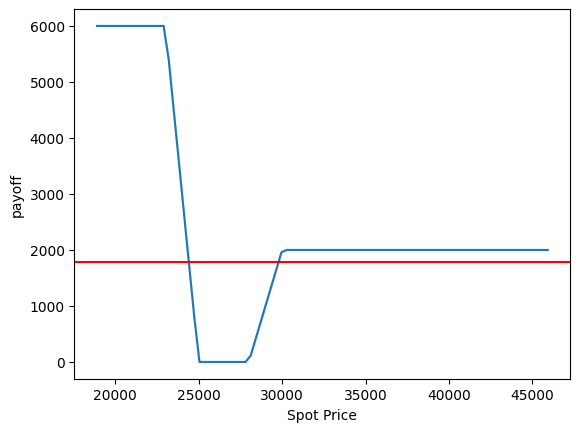

[       Price
0  343.85288,         Price
0  785.887708,         Price
0  862.943254,         Price
0  407.469281]
net premium 1781.5784551542079
premium 4659.634297334289
Risk Reward 2.367800044192081
probal 0.797752808988764
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 25043.23119035707
best case, vol: 0.85 price: 18900.608770731193
min thetas -17.5030232627864
[{'type': 'P', 'strike': 23000.0, 'expiry': 0.10813552311938737, 'vol': 0.4643, 'quantity': -3, 'map': -1}, {'type': 'P', 'strike': 25000.0, 'expiry': 0.10813552311938737, 'vol': 0.428, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 28000.0, 'expiry': 0.10813552311938737, 'vol': 0.4086, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 30000.0, 'expiry': 0.10813552311938737, 'vol': 0.4189, 'quantity': -1, 'map': -1}]


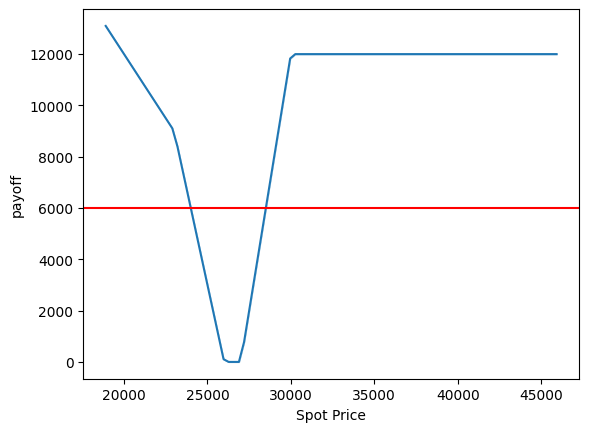

[       Price
0  343.85288,         Price
0  1147.87744,          Price
0  1217.165422,         Price
0  407.469281]
net premium 5994.711125508531
premium 10629.876891569806
Risk Reward 1.1851580426500679
probal 0.8314606741573034
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 26271.75567428225
best case, vol: 0.85 price: 18900.608770731193
min thetas -49.17931960115027
[{'type': 'P', 'strike': 23000.0, 'expiry': 0.10813552311938737, 'vol': 0.4643, 'quantity': -2, 'map': -1}, {'type': 'P', 'strike': 26000.0, 'expiry': 0.10813552311938737, 'vol': 0.41409999999999997, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10813552311938737, 'vol': 0.4025, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 30000.0, 'expiry': 0.10813552311938737, 'vol': 0.4189, 'quantity': -4, 'map': -1}]


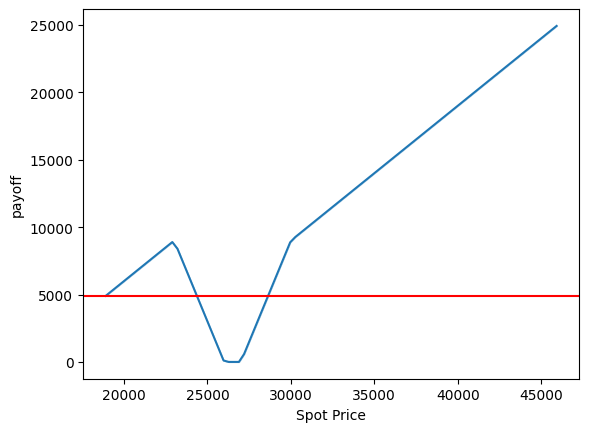

[       Price
0  343.85288,         Price
0  1147.87744,          Price
0  1217.165422,         Price
0  407.469281]
net premium 4904.778504182302
premium 9285.478668010655
Risk Reward 4.082420622221542
probal 0.8314606741573034
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 26271.75567428225
best case, vol: 0.85 price: 45928.147417085056
min thetas -34.243504347629255
[{'type': 'P', 'strike': 23000.0, 'expiry': 0.10813552311938737, 'vol': 0.4643, 'quantity': -4, 'map': -1}, {'type': 'P', 'strike': 26000.0, 'expiry': 0.10813552311938737, 'vol': 0.41409999999999997, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10813552311938737, 'vol': 0.4025, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 30000.0, 'expiry': 0.10813552311938737, 'vol': 0.4189, 'quantity': -2, 'map': -1}]


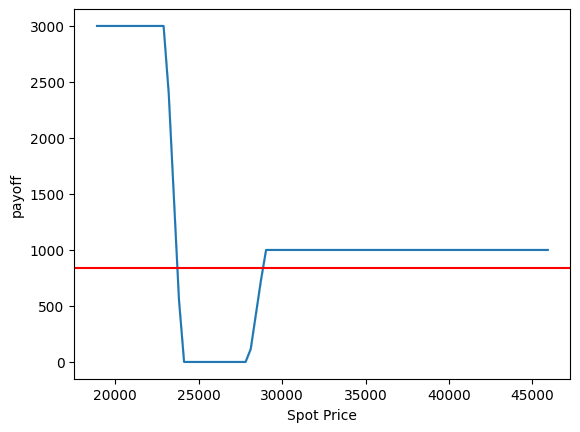

[       Price
0  343.85288,         Price
0  530.923074,         Price
0  862.943254,         Price
0  589.258633]
net premium 834.8952026611406
premium 4076.5297485316714
Risk Reward 2.5932653468816396
probal 0.8089887640449438
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 24121.83782741319
best case, vol: 0.85 price: 18900.608770731193
min thetas -9.419085345078713
[{'type': 'P', 'strike': 23000.0, 'expiry': 0.10813552311938737, 'vol': 0.4643, 'quantity': -3, 'map': -1}, {'type': 'P', 'strike': 24000.0, 'expiry': 0.10813552311938737, 'vol': 0.4472, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 28000.0, 'expiry': 0.10813552311938737, 'vol': 0.4086, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 29000.0, 'expiry': 0.10813552311938737, 'vol': 0.4108, 'quantity': -1, 'map': -1}]


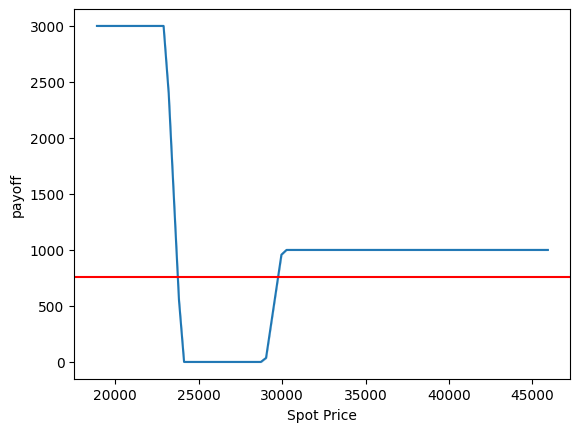

[       Price
0  343.85288,         Price
0  530.923074,         Price
0  602.278786,         Price
0  407.469281]
net premium 756.0200863714001
premium 3634.075928551481
Risk Reward 2.9681485374268606
probal 0.7752808988764045
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 24121.83782741319
best case, vol: 0.85 price: 18900.608770731193
min thetas -9.93538186002587
[{'type': 'P', 'strike': 23000.0, 'expiry': 0.10813552311938737, 'vol': 0.4643, 'quantity': -3, 'map': -1}, {'type': 'P', 'strike': 24000.0, 'expiry': 0.10813552311938737, 'vol': 0.4472, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 29000.0, 'expiry': 0.10813552311938737, 'vol': 0.4152, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 30000.0, 'expiry': 0.10813552311938737, 'vol': 0.4189, 'quantity': -1, 'map': -1}]


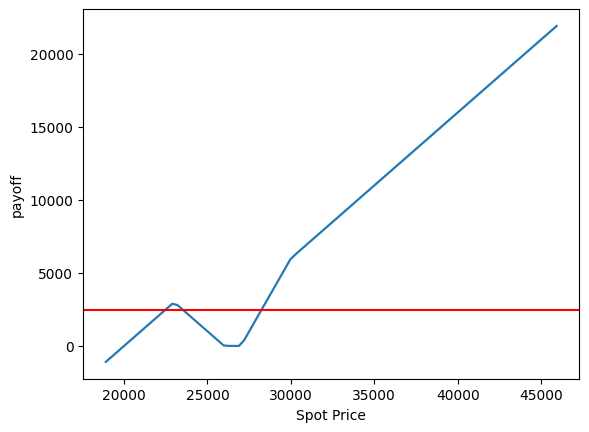

[       Price
0  343.85288,         Price
0  1147.87744,          Price
0  1217.165422,         Price
0  407.469281]
net premium 2487.0332435177615
premium 4677.383325431938
Risk Reward 5.420751035211958
probal 0.6966292134831461
lowest possible premium -1099.3912292688074
max loss [1.44204927]
worst case, vol: 0.85 price: 18900.608770731193
best case, vol: 0.85 price: 45928.147417085056
min thetas -18.288125752180008
[{'type': 'P', 'strike': 23000.0, 'expiry': 0.10813552311938737, 'vol': 0.4643, 'quantity': -2, 'map': -1}, {'type': 'P', 'strike': 26000.0, 'expiry': 0.10813552311938737, 'vol': 0.41409999999999997, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10813552311938737, 'vol': 0.4025, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 30000.0, 'expiry': 0.10813552311938737, 'vol': 0.4189, 'quantity': -1, 'map': -1}]


In [22]:
# bule line is the payoff curve, red line stands for net premium, yep this is for plotting
for para in temp.para[:10]:
    model.model_plot(para)